In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson
import scipy

Я наткнулся на новость, то что на момент октября 2020 года, цена на однокомнатную квартиру в Москве составляет 9,1 млн рублей https://1prime.ru/20201209/832537224.html, давайте проверим на самом деле, это так, c помощью статистических инструментов. 

In [255]:
price_russia = pd.read_csv('all_v2.csv') 

Датасет https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021 содержит основную информацию по объявлениям квартир в россии на промежутке 2018-2021 год

В рамках исследования, нам нужно отфильтровать данные, чтобы условия совпадали с источником новости 
(Москва, август 2020 года, однокомнатная квартира)

In [256]:
price_russia['date'] = price_russia['date'].astype('datetime64[ns]')
price_russia_moscow = price_russia[(price_russia['region'] == 3) &
(price_russia['date'].dt.year == 2020) &
(price_russia['date'].dt.month == 10) &
(price_russia['rooms'] == 1)]

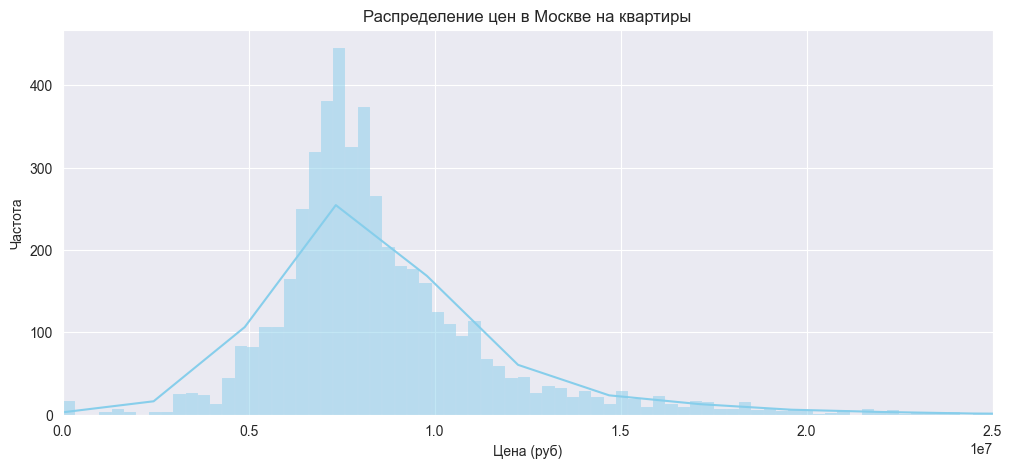

In [257]:
plt.figure(figsize=(12,5))
sns.histplot(price_russia_moscow['price'], kde=True, color='skyblue')
plt.xlim(0,25000000)
plt.title('Распределение цен в Москве на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Частота')
plt.show()

### Гипотеза 1 - Цены на однокомнатные квартиры в Москве, в авгусе 2020 года отличаются от заявленных 9.1 млн рублей. 

#### a) Вычисление точечных оценок

In [258]:
# Для теста возьмём выборку размером 30
n = 30
sample = price_russia_moscow['price'].sample(n, random_state=1) # Выборка была отобрана с помощью случайного сэмплирования, где каждый элемент ГС, может с равной вероятностью попасть в выборку.

In [259]:
# Посчитаем основные точечные оценки для случайной величины

sample_mean = sample.mean()
sample_var = sample.var(ddof=1) # ddof = 1 значит мы используем формулу дисперсии для выборки
sample_std = sample.std(ddof = 1)
sample_median = sample.median()
sample_mode = sample.mode()
sample_min = sample.min()
sample_max = sample.max()

print(f"""
1. Описательные статистика для распределения цен на квартиры:
   1. Среднее: {sample_mean:.2f}
   2. Дисперсия: {sample_var:.2f}
   3. Стандартное отклонение: {sample_std:.2f}
   4. Медиана: {sample_median:.2f}
   5. Мода: {sample_mode.values[0]}
   6. Минимум: {sample_min}
   7. Максимум: {sample_max}
""")


1. Описательные статистика для распределения цен на квартиры:
   1. Среднее: 7948531.23
   2. Дисперсия: 4046138236020.67
   3. Стандартное отклонение: 2011501.49
   4. Медиана: 8045560.00
   5. Мода: 7000000
   6. Минимум: 3300000
   7. Максимум: 10992210



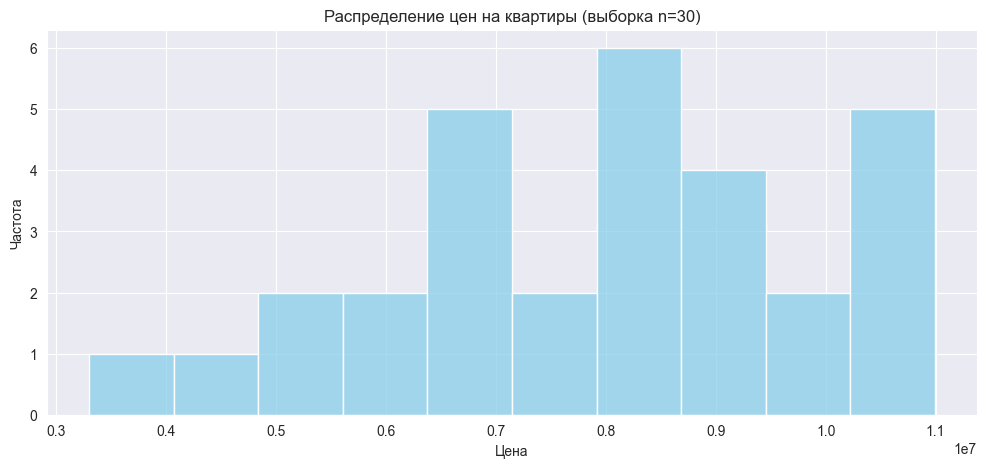

In [290]:
# Распределение цен на квартиры
plt.figure(figsize=(12, 5))
sns.histplot(data=sample, bins = 10, color='skyblue')
plt.title('Распределение цен на квартиры (выборка n=30)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Основываясь на графике мы можем предположить, что цена имеет нормальное распределение.
Но нужно провести дополнительный тест, который проверит распределение на нормальность и мы сможем уверенно работать с распределением как с нормальным, для этого воспользуемся тестом Шапиро-Уилка.

**Тест Шапиро-Уилка** — это мощный статистический тест, используемый для проверки гипотезы о том, что случайная выборка данных взята из нормально распределенной популяции. Он особенно хорошо подходит для небольших и средних размеров выборки.

Статистика теста Шапиро-Уилка определяется следующим образом:
$$W = \frac{\left(\sum_{i=1}^{n} a_i x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2} $$
- $x_i$— i-й по величине элемент упорядоченной выборки.
 
- $a_i$ — коэффициенты Шапиро-Уилка (веса) из таблицы.
 
- $\bar{x}$— выборочное среднее.
 
- $n$— размер выборки.

**Формулировка гипотез**

$H_0$ - распределение цен на квартиру нормально

$H_1$ - распределение не нормально

При $\alpha = 0.05$ 

Если $( p\text{-value} < 0.05$, то $H_0$ отвергается)

In [261]:
a = 0.05
p_value_for_price = shapiro(sample)
print(f'p-value = {p_value_for_price[1]:.8f}')
if p_value_for_price[1] > a:
    print(f'p-value > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости {a}')
else:
    print(f'p-value < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости {a}')

p-value = 0.44175776
p-value > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости 0.05



Значит мы можем утверждать, что

X - Цена (Случайная величина)

$X\sim N(\mu,\sigma^2)$


**Метод Максимального Правдоподобия (ММП)** — это статистический метод оценки параметров распределения случайной величины, при котором выбираются такие значения параметров, при которых наблюдаемые данные наиболее вероятны.

Если случайная величина имеет распределение нормальное, то по ММП взяв его логарифм и с помощью частных производных мы можем определить следующие оценки параметров нормального распределения

$L(\mu, \sigma^2 | x_1, …, x_n) = \prod_{i=1}^{n} f(x_i | \mu, \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)$ 

1. **Оценка среднего**:
   $$
   \frac{\partial \ln L}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^{n} (x_i - \mu) = 0
   $$

   $$ \hat{\mu}_{ММП} = \frac{1}{n} \sum_{i=1}^{n} x_i = \bar{x} $$

2. **Оценка дисперсии**:

    $$\frac{\partial \ln L}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2} \sum_{i=1}^{n} (x_i - \mu)^2 = 0$$
   $$
   \hat{\sigma}^2_{\text{ММП}} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
   $$

Эти оценки ММП являются “лучшими” в том смысле, что они максимизируют функцию правдоподобия, и, при достаточной выборке, обладают хорошими статистическими свойствами.

Оценка дисперсии $\hat{\sigma}^2_{\text{ММП}}$ **смещённая**, но **состоятельная** (при $n \to \infty $) смещение стремится к 0
   

In [262]:
mmp_mean = sample_mean 
mmp_var = sample.var(ddof = 0)  # Используется смещённая формула дисперсии
print(f"ММП-оценка среднего: {mmp_mean:.2f}")
print(f"ММП-оценка дисперсии: {mmp_var:.2f}")

ММП-оценка среднего: 7948531.23
ММП-оценка дисперсии: 3911266961486.65


Также стоит проверить эффективность оценки дисперсии. Это можно сделать с помощью неравенства Рао-Крамера 

*Неравенство Рао-Крамера (Rao-Cramér Inequality), также известное как граница Рао-Крамера, предоставляет фундаментальное ограничение на точность любой несмещенной оценки параметра. Оно устанавливает нижнюю границу для дисперсии любой несмещенной оценки, что позволяет определить, насколько “хороша” оценка.*

**Проверим на эффективность смещённую оценку дисперсии**

**1. Определение оценки**
   $$
   \hat{\sigma}^2_{\text{ММП}} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
   $$
**2. Вычисление информации Фишера**

$$
I(\theta) = -E\left[ \frac{\partial^2}{\partial \theta^2} \ln L(\theta | X) \right]
$$

$$
\ln L(\mu, \sigma^2 | X) = -\frac{n}{2}\ln(2\pi) - \frac{n}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$$

- Первая производная по $\sigma$:
    $$\frac{\partial \ln L}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2(\sigma^2)^2} \sum_{i=1}^{n} (x_i - \mu)^2$$

- Вторая производная по  $\sigma$:
    $$\frac{\partial^2 \ln L}{\partial (\sigma^2)^2} = \frac{n}{2(\sigma^2)^2} - \frac{1}{(\sigma^2)^3} \sum_{i=1}^{n} (x_i - \mu)^2 $$

- Берём - Мат ожидание от выражения и получаем
$$I(\sigma^2) = -\left[ \frac{n}{2σ^4} - \frac{n}{σ^4} \right] = -\left[ -\frac{n}{2σ^4} \right] = \frac{n}{2σ^4}$$

**3. Вычисление дисперсии**
$$Var(\hat{\sigma}^2_{ММП}) = \frac{2\sigma^4}{n} $$

**4. Сравнение с нижней границей Рао-Крамера**

Нижняя граница Рао-Крамера для дисперсии оценки:

$$ \frac{1}{I(\sigma^2)} = \frac{1}{\frac{n}{2\sigma^4}} = \frac{2\sigma^4}{n} $$

Мы видим, что $Var(\hat{\sigma}^2_{ММП}) = \frac{2\sigma^4}{n}$ , что в точности равно нижней границе Рао-Крамера.

**5. Вывод**
Вывод: ММП оценка для дисперсии достигает нижней границы Рао-Крамера, что делает ее эффективной.

#### b) Построение доверительных интервалов 

Построим 95% доверительный интервал, для наших параметров. Начнём с $\mu$
Так как выборку мы выбрали не большую n >= 30, для нахождения доверительного интервала мы воспользуемся t-статистикой с 29 степенями свободы.

Тогда формула для доверительного интервала будет такая:
$$
\bar{x} \pm t_{\alpha/2, \, n-1} \cdot \frac{s}{\sqrt{n}},
$$
где:
- $\bar{x}$ — выборочное среднее,
- $t_{\alpha/2, \, n-1}$ — критическое значение t-распределения,
- $s$ — выборочное стандартное отклонение,
- $n$ — размер выборки.


In [263]:
alpha = 0.05
t_stat = scipy.stats.t.ppf(1 - alpha / 2, df = n - 1) # 29 степеней свободы

t_lower = sample_mean - t_stat * sample_std/np.sqrt(n)
t_upper = sample_mean + t_stat * sample_std/np.sqrt(n)
print(f'Доверительный интервал для матожидания цены [{t_lower:.0f}, {t_upper:.0f}] рублей')

Доверительный интервал для матожидания цены [7197424, 8699638] рублей


Теперь 95% доверительный интервал для $\sigma$
$$
\left[ \frac{(n-1)s^2}{\chi^2_{\alpha/2, \, n-1}}, \quad \frac{(n-1)s^2}{\chi^2_{1-\alpha/2, \, n-1}} \right],
$$
где:
- $ n$ — размер выборки,
- $s^2$ — выборочная дисперсия,
- $\chi^2_{\alpha/2, \, n-1}$ и $\chi^2_{1-\alpha/2, \, n-1}$ — критические значения χ²-распределения.

In [264]:
alpha = 0.05
xi_lower = scipy.stats.chi2.ppf(1 - alpha / 2, df = n - 1)
xi_upper = scipy.stats.chi2.ppf(alpha / 2, df = n - 1)

xi_lower_stat = ((n - 1) * sample_std)/ xi_lower
xi_upper_stat = ((n - 1) * sample_std)/ xi_upper

print(f'Доверительный интервал для стандартного отклонения цены [{xi_lower_stat:.0f}, {xi_upper_stat:.0f}] рублей')

Доверительный интервал для стандартного отклонения цены [1275823, 3635152] рублей


#### с) Проверка статистических гипотез
Проверим отличается ли цены на однокомнатные квартиры в Москве, в авгусе 2020 года от заявленных 9.1 млн рублей при уровне значимости $\alpha = 0.05$

$H_0 - \mu_{\text{цена на квартиры в москве}} = 9.1$ млн рублей

$H_1 - \mu_{\text{цена на квартиры в москве}}\neq 9.1$ млн рублей 

$$\bar{X} \sim N(\mu, \frac{s^2}{n})$$

$$SE = \frac{s}{\sqrt n}$$

$$T = \frac{\bar{X} - \mu}{\frac{s}{\sqrt n}} \sim t(n-1)$$

In [265]:
alpha = 0.05
SE = sample_std/np.sqrt(n)
T = (sample_mean - 9100000)/SE
t_stat = scipy.stats.t.ppf(1 - alpha / 2, df = n - 1) # 29 степеней свободы

p_value = 2 * (1 - scipy.stats.t.cdf(abs(T), df=n-1))


print("T-статистика:", T)
print("Критическое значение t-статистики:", t_stat)
print("p-значение:", p_value)


if p_value < alpha:
    print(f'p-value < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости {a}')
else:
    print(f'p-value > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости {a}')

T-статистика: -3.135396227865011
Критическое значение t-статистики: 2.045229642132703
p-значение: 0.003911567440712416
p-value < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости 0.05




p-value > 0.05. **Нет статистической значимости отвергнуть $H_0$ при уровне значимости 0.05**

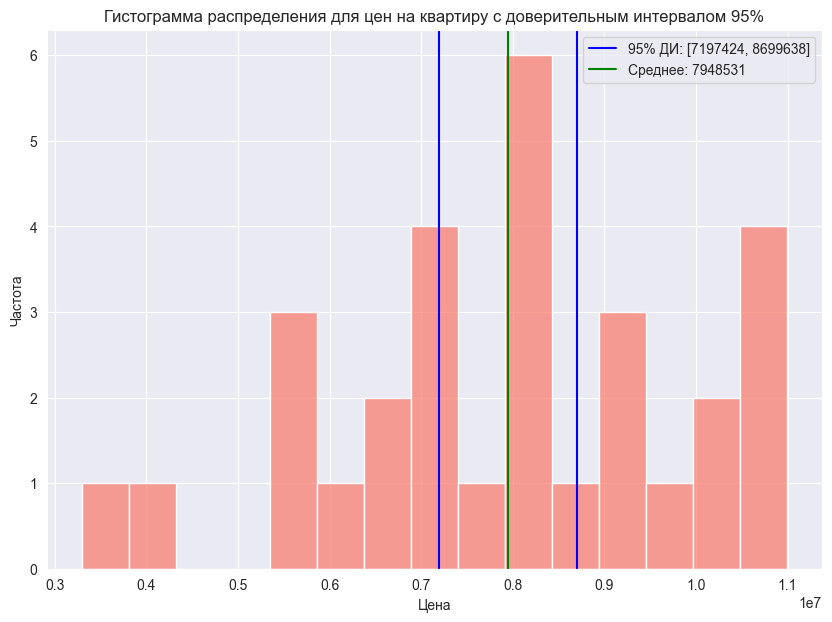

In [288]:
plt.figure(figsize = (10,7))
sns.histplot(sample, bins = 15,color='salmon')
plt.axvline(t_lower, color = 'blue',  label=f'95% ДИ: [{t_lower:.0f}, {t_upper:.0f}]')
plt.axvline(sample_mean, label = f'Среднее: {sample_mean:.0f}', color = 'green')
plt.axvline(t_upper, color = 'blue')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Гистограмма распределения для цен на квартиру с доверительным интервалом 95%')
plt.legend()
plt.show()

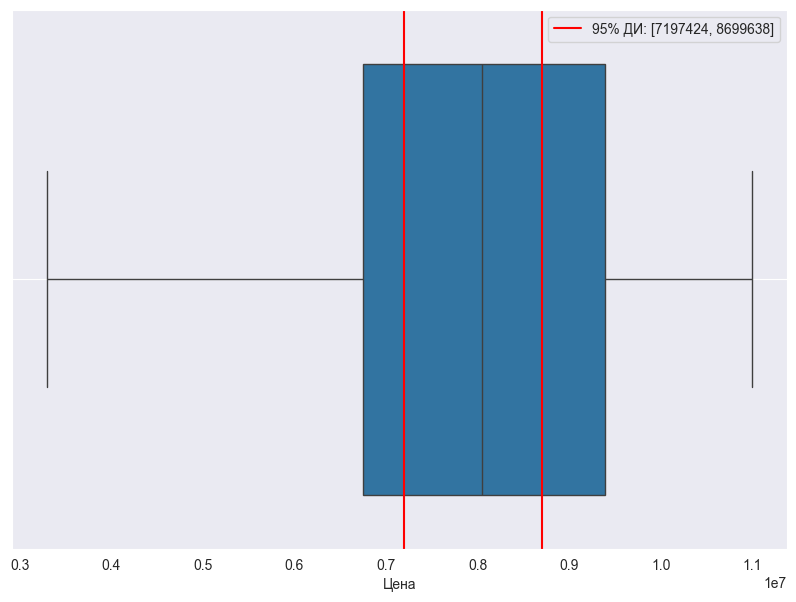

In [279]:
plt.figure(figsize = (10,7))
sns.boxplot(sample, orient  = 'h')
plt.axvline(t_lower, color = 'red', label=f'95% ДИ: [{t_lower:.0f}, {t_upper:.0f}]')
plt.axvline(t_upper, color = 'red')
plt.xlabel('Цена')
plt.grid()
plt.legend()
plt.show()

## Гипотеза 2 Отличаются ли стоимость квартиры построенных из монолита и построенных из кирпича в Москве

Если подумать, то естественно дома из монолита должны стоить дороже домов из кирпича, но стоит всё-же на это посмотреть со статистической точки зрения

In [268]:
n = 30

price_brick = price_russia_moscow.query('building_type == 3 ')['price'].sample(int(n/2), random_state = 42)
price_monolith = price_russia_moscow.query('building_type == 2')['price'].sample(int(n/2), random_state = 42)
    

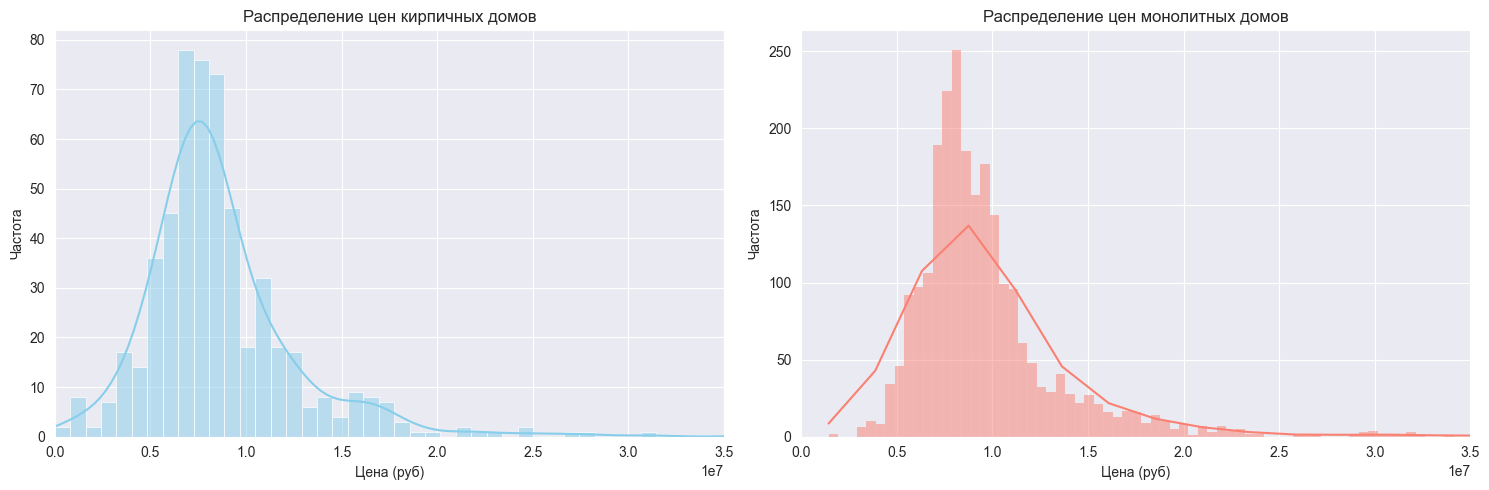

In [276]:

data_1 = price_russia_moscow.query('building_type == 3')['price']
data_2 = price_russia_moscow.query('building_type == 2')['price']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_1, kde=True, ax=axes[0], color='skyblue')
axes[0].set_xlim(0, 35_000_000)
axes[0].set_title('Распределение цен кирпичных домов')
axes[0].set_xlabel('Цена (руб)')
axes[0].set_ylabel('Частота')

sns.histplot(data_2, kde=True, ax=axes[1], color='salmon')
axes[1].set_xlim(0, 35_000_000)
axes[1].set_title('Распределение цен монолитных домов')
axes[1].set_xlabel('Цена (руб)')
axes[1].set_ylabel('Частота')

plt.tight_layout() 
plt.show()

In [270]:
brick_mean = price_brick.mean()
brick_var = price_brick.var(ddof=1) # ddof = 1 значит мы используем формулу дисперсии для выборки
brick_std = price_brick.std(ddof = 1)
brick_median = price_brick.median()
brick_mode = price_brick.mode()
brick_min = price_brick.min()
brick_max = price_brick.max()

print(f"""
1. Описательные статистики для распределения цен на квартиры из кирпича:
   1. Среднее: {brick_mean:.2f}
   2. Дисперсия: {brick_var:.2f}
   3. Стандартное отклонение: {brick_std:.2f}
   4. Медиана: {brick_median:.2f}
   5. Мода: {brick_mode.values[0]}
   6. Минимум: {brick_min}
   7. Максимум: {brick_max}
""")

monolith_mean = price_monolith.mean()
monolith_var = price_monolith.var(ddof=1) # ddof = 1 значит мы используем формулу дисперсии для выборки
monolith_std = price_monolith.std(ddof = 1)
monolith_median = price_monolith.median()
monolith_mode = price_monolith.mode()
monolith_min = price_monolith.min()
monolith_max = price_monolith.max()

print(f"""
2. Описательные статистики для распределения цен на квартиры из монолита:
   1. Среднее: {monolith_mean:.2f}
   2. Дисперсия: {monolith_var:.2f}
   3. Стандартное отклонение: {monolith_std:.2f}
   4. Медиана: {monolith_median:.2f}
   5. Мода: {monolith_mode.values[0]}
   6. Минимум: {monolith_min}
   7. Максимум: {monolith_max}
""")


1. Описательные статистики для распределения цен на квартиры из кирпича:
   1. Среднее: 8120088.00
   2. Дисперсия: 8406947591588.57
   3. Стандартное отклонение: 2899473.67
   4. Медиана: 7900000.00
   5. Мода: 3750000
   6. Минимум: 3750000
   7. Максимум: 13800000


2. Описательные статистики для распределения цен на квартиры из монолита:
   1. Среднее: 9390385.67
   2. Дисперсия: 13695965598410.24
   3. Стандартное отклонение: 3700806.07
   4. Медиана: 9139910.00
   5. Мода: 6032000
   6. Минимум: 5577190
   7. Максимум: 18005000



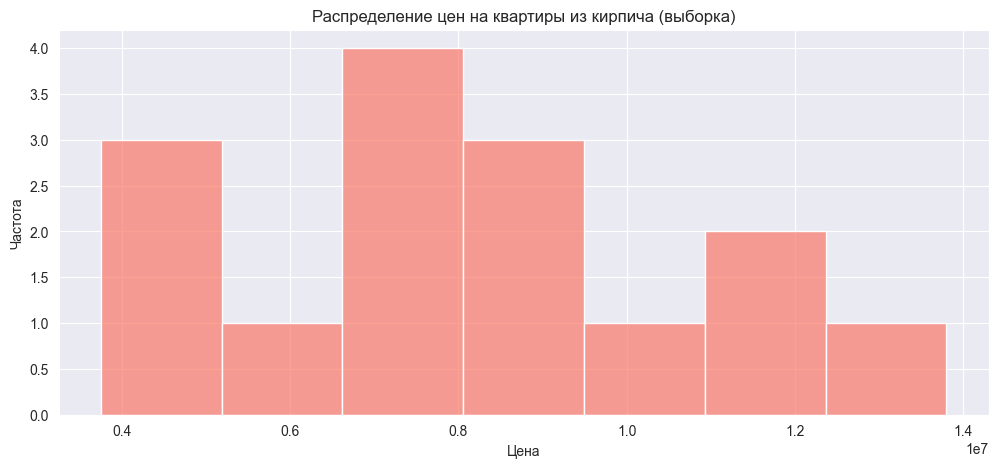

In [285]:
plt.figure(figsize=(12, 5))
sns.histplot(data=price_brick, bins = 7, color='salmon')
plt.title('Распределение цен на квартиры из кирпича (выборка)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

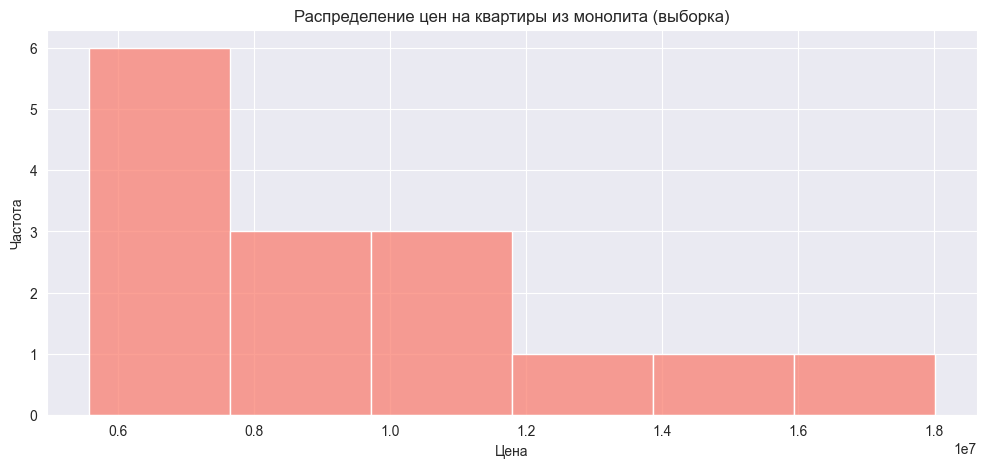

In [286]:
plt.figure(figsize=(12, 5))
sns.histplot(data=price_monolith, bins = 6,color='salmon')
plt.title('Распределение цен на квартиры из монолита (выборка)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

$H_0$ - распределение цен на квартиру из кирпичей/монолита нормально

$H_1$ - распределение не нормально

При $\alpha = 0.05$ 

Если $( p\text{-value} < 0.05$, то $H_0$ отвергается)

In [273]:
a = 0.05

p_value_for_price_brick = shapiro(price_brick)
p_value_for_monolith = shapiro(price_monolith)

print(f'p-value - для кирпичных домов = {p_value_for_price_brick[1]:.8f}\n'
      f'p-value - для монолитных домов = {p_value_for_monolith[1]:.8f}\n')


if p_value_for_price_brick[1] > a:
    print(f'p-value - для кирпичных домов > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости {a}')
else:
    print(f'p-value - для кирпичных домов < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости {a}')
if p_value_for_monolith[1] > a:
    print(f'p-value - для монолитных домов > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости {a}')
else:
    print(f'p-value - для монолитных домов < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости {a}')

p-value - для кирпичных домов = 0.78227420
p-value - для монолитных домов = 0.05462809

p-value - для кирпичных домов > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости 0.05
p-value - для монолитных домов > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости 0.05


**Оба распределения нормальны**, поэтому мы можем воспользоваться тестами для нормального распределения

У нас выборки маленькие и дисперсии разные, поэтому воспользуемся t-тестом для сравнения двух выборок.

Проверим отличаются ли цены на квартиры в домах из кирпича и в домах из монолита
$$
H_0: \mu_{\text{цена на дома из кирпича}} = \mu_{\text{цена на дома из монолита}}
$$
$$
H_1: \mu_{\text{цена на дома из кирпича}} \neq \mu_{\text{цена на дома из монолита}}
$$



**Если дисперсии неравны (тест Уэлча):**
1. **t-статистика**:  
   $$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $$  

2. **Пересчёт степеней свободы** (формула Уэлча):  
   $$ df = \frac{\left( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2}{\frac{(s_1^2/n_1)^2}{n_1 - 1} + \frac{(s_2^2/n_2)^2}{n_2 - 1}} $$  


In [274]:
alpha = 0.05

t_stat, p_value = scipy.stats.ttest_ind(price_brick, price_monolith, equal_var=False)
print(f"t = {t_stat:.3f}, p-value = {p_value:.3f}")

if p_value > alpha:
    print(f'p-value > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости {alpha}')
else:
    print(f'p-value < 0.05 - есть статистические основания отвергнуть нулевую гипотезу при уровне значимости {alpha}')

t = -1.046, p-value = 0.305
p-value > 0.05 - нет статистических оснований отвергать нулевую гипотезу при уровне значимости 0.05


Нет статистических оснований полагать, что есть какая-нибудь разница в стоимости домов из кирпича или из монолита. Хотя подумать, до теста была уверенность, то что отличия существенны, а статистика говорит об обратном